<h2 style="text-align: center; color: orange;"><b>TASK 4</b></h2>

<h3 style="text-align: left; color: orange;"><b>Stock Price Forecasting</b></h3>

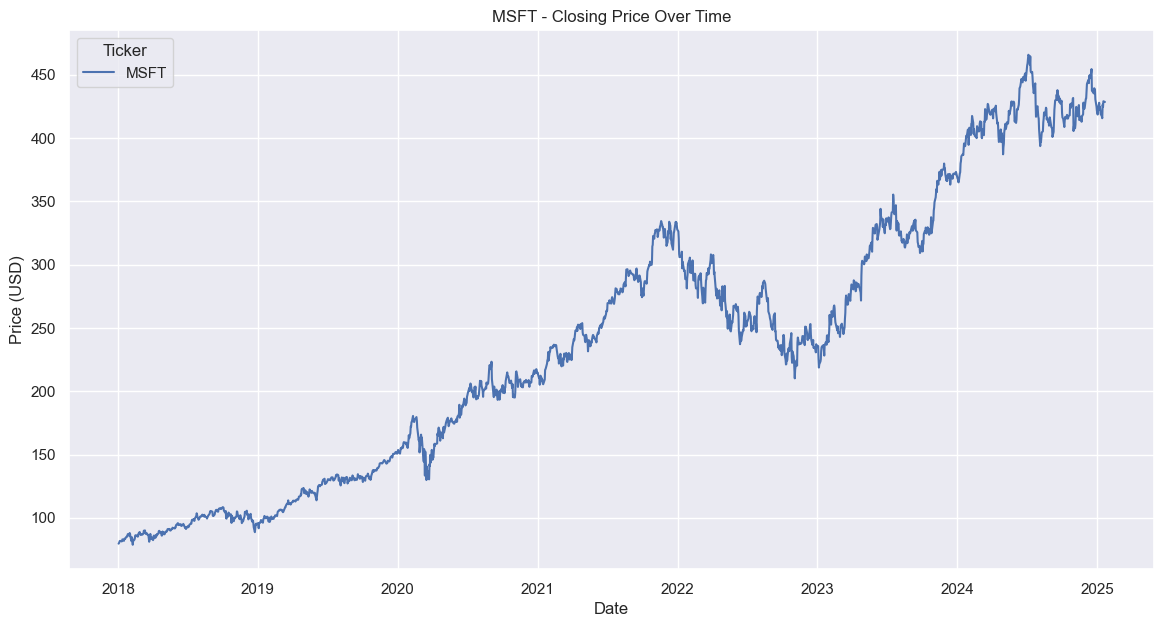

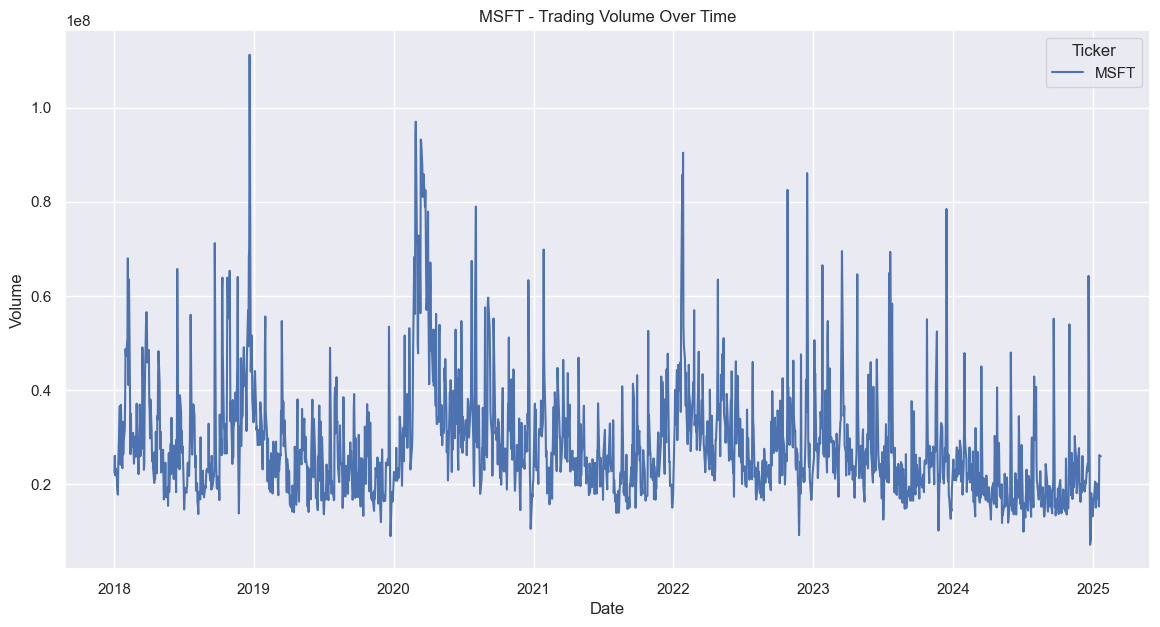

Independent Features (X_train): (1352, 60, 5)
Dependent Features (y_train): (1352, 7)
Number of Training Samples: 1352
Number of Testing Samples: 289


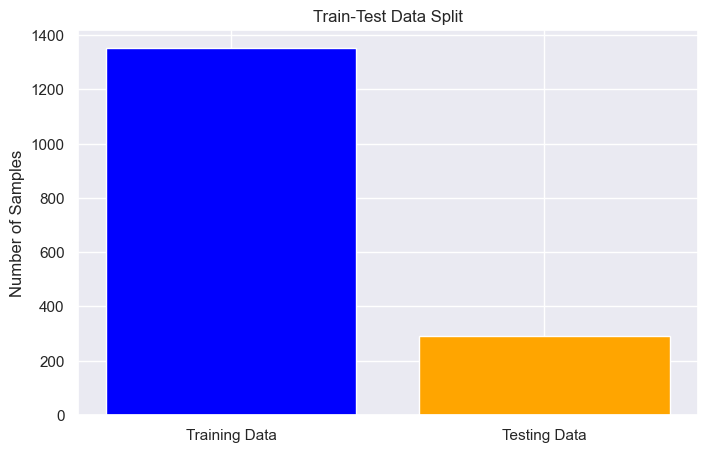

Epoch 1/20
85/85 [==============================] - 14s 68ms/step - loss: 0.0162
Epoch 2/20
85/85 [==============================] - 7s 79ms/step - loss: 0.0035
Epoch 3/20
85/85 [==============================] - 7s 81ms/step - loss: 0.0025
Epoch 4/20
85/85 [==============================] - 7s 82ms/step - loss: 0.0022
Epoch 5/20
85/85 [==============================] - 7s 80ms/step - loss: 0.0019
Epoch 6/20
85/85 [==============================] - 10s 123ms/step - loss: 0.0017
Epoch 7/20
85/85 [==============================] - 11s 130ms/step - loss: 0.0014
Epoch 8/20
85/85 [==============================] - 11s 127ms/step - loss: 0.0013
Epoch 9/20
85/85 [==============================] - 9s 101ms/step - loss: 0.0013
Epoch 10/20
85/85 [==============================] - 8s 96ms/step - loss: 0.0013
Epoch 11/20
85/85 [==============================] - 8s 94ms/step - loss: 0.0012
Epoch 12/20
85/85 [==============================] - 9s 111ms/step - loss: 0.0011
Epoch 13/20
85/85 [=========

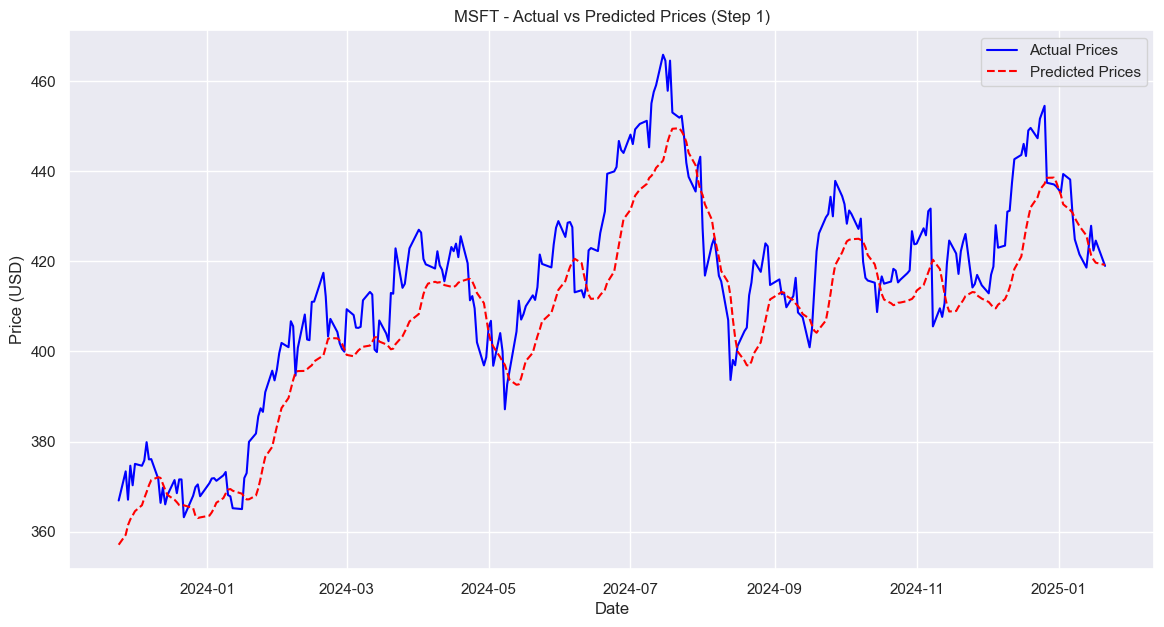

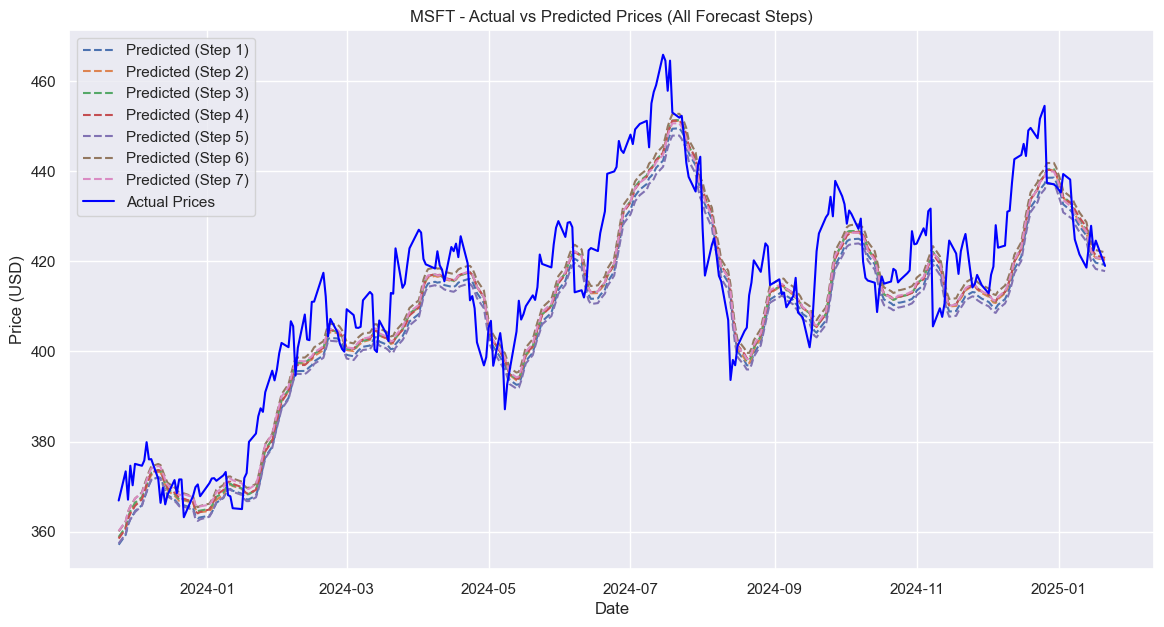

In [20]:
# Import required libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Function to fetch historical stock data
def get_stock_data(ticker, start_date):
    stock_data = yf.download(ticker, start=start_date, progress=False)
    return stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Fetch data
ticker = "MSFT"
start_date = "2018-01-01"
stock_data = get_stock_data(ticker, start_date)

# Visualizing stock data using Seaborn
sns.set(style="darkgrid")

# Close Price Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data['Close'], color='blue')
plt.title(f'{ticker} - Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

# Volume Over Time
plt.figure(figsize=(14, 7))
sns.lineplot(data=stock_data['Volume'], color='purple')
plt.title(f'{ticker} - Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# Prepare multi-step data
def prepare_multi_step_data(data, time_steps=60, forecast_steps=7):
    X, y = [], []
    for i in range(len(data) - time_steps - forecast_steps + 1):
        X.append(data[i:i + time_steps])
        y.append([data[i + time_steps + j, 3] for j in range(forecast_steps)])  # Close prices
    return np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare data for LSTM
time_steps = 60
forecast_steps = 7
X_train, y_train = prepare_multi_step_data(train_data, time_steps, forecast_steps)
X_test, y_test = prepare_multi_step_data(test_data, time_steps, forecast_steps)

# Reshaping data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Print dataset information
print(f"Independent Features (X_train): {X_train.shape}")
print(f"Dependent Features (y_train): {y_train.shape}")
print(f"Number of Training Samples: {len(X_train)}")
print(f"Number of Testing Samples: {len(X_test)}")

# Visualize train-test split
plt.figure(figsize=(8, 5))
plt.bar(['Training Data', 'Testing Data'], [len(X_train), len(X_test)], color=['blue', 'orange'])
plt.title('Train-Test Data Split')
plt.ylabel('Number of Samples')
plt.show()

# Build the LSTM model
def build_lstm_model(input_shape, forecast_steps):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=forecast_steps)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train the model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]), forecast_steps)
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse scaling of predictions and actual values
def inverse_scale_predictions_multi_step(predictions, y_test, scaler):
    predictions_actual, y_test_actual = [], []
    for i in range(predictions.shape[0]):
        pred_set, actual_set = [], []
        for step in range(predictions.shape[1]):
            pred = np.zeros((scaled_data.shape[1],))
            actual = np.zeros((scaled_data.shape[1],))
            pred[3] = predictions[i, step]
            actual[3] = y_test[i, step]
            pred_set.append(scaler.inverse_transform([pred])[0, 3])
            actual_set.append(scaler.inverse_transform([actual])[0, 3])
        predictions_actual.append(pred_set)
        y_test_actual.append(actual_set)
    return np.array(predictions_actual), np.array(y_test_actual)

predictions_actual, y_test_actual = inverse_scale_predictions_multi_step(predictions, y_test, scaler)

# Evaluation metrics
for step in range(forecast_steps):
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, step], predictions_actual[:, step]))
    mae = mean_absolute_error(y_test_actual[:, step], predictions_actual[:, step])
    print(f"Step {step + 1}: RMSE = {rmse:.2f}, MAE = {mae:.2f}")

# Visualize actual vs. predicted for a specific step
step_to_plot = 1
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-len(y_test_actual):], y_test_actual[:, step_to_plot - 1], label='Actual Prices', color='blue')
plt.plot(stock_data.index[-len(predictions_actual):], predictions_actual[:, step_to_plot - 1], linestyle='dashed', color='red', label='Predicted Prices')
plt.title(f'{ticker} - Actual vs Predicted Prices (Step {step_to_plot})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Overlay all forecast steps
plt.figure(figsize=(14, 7))
for step in range(forecast_steps):
    plt.plot(stock_data.index[-len(y_test_actual):], predictions_actual[:, step], linestyle='dashed', label=f'Predicted (Step {step + 1})')
plt.plot(stock_data.index[-len(y_test_actual):], y_test_actual[:, 0], label='Actual Prices', color='blue')
plt.title(f'{ticker} - Actual vs Predicted Prices (All Forecast Steps)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
